In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import lightgbm as lgb

C:\Users\Public\Anaconda\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\Public\Anaconda\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# Feature selection

In [2]:
training_data = pd.read_csv('training_set_VU_DM.csv') 

In [3]:
training_data['date_time'] = pd.to_datetime(training_data['date_time'])

training_data['Cin_hour'] = training_data["date_time"].apply(lambda x: x.hour)
training_data['Cin_day'] = training_data["date_time"].apply(lambda x: x.day)
training_data['Cin_month'] = training_data["date_time"].apply(lambda x: x.month)
training_data['Cin_quarter'] = training_data["date_time"].apply(lambda x: x.quarter)
training_data['Cin_day_of_week'] = training_data['date_time'].dt.dayofweek+1 #we don't want zeros

training_data.drop('date_time',axis=1,inplace=True)

In [4]:
training_data['priceRank'] = training_data.groupby('srch_id')['price_usd'].rank()
training_data['starRank'] = training_data.groupby('srch_id')['prop_starrating'].rank()
training_data['reviewRank'] = training_data.groupby('srch_id')['prop_review_score'].rank()
training_data['location1Rank'] = training_data.groupby('srch_id')['prop_location_score1'].rank()
training_data['location2Rank'] = training_data.groupby('srch_id')['prop_location_score2'].rank()
training_data['histpriceRank'] = training_data.groupby('srch_id')['prop_log_historical_price'].rank()

In [5]:
training_data['rating_diff']=abs(training_data['visitor_hist_starrating']-training_data['prop_starrating'])
training_data['rating_diff']=training_data['rating_diff'].fillna(training_data['rating_diff'].mean())

training_data['price_diff']=abs(training_data['visitor_hist_adr_usd']-training_data['price_usd'])
training_data['price_diff']=training_data['price_diff'].fillna(training_data['price_diff'].mean())

In [6]:
# creating new features
training_data['competitor_rate'] = (training_data.comp1_rate + training_data.comp2_rate + training_data.comp3_rate +
                                    training_data.comp4_rate + training_data.comp5_rate + training_data.comp6_rate +
                                    training_data.comp7_rate + training_data.comp8_rate)

training_data['competitor_inv'] = (training_data.comp1_inv + training_data.comp2_inv + training_data.comp3_inv +
                                    training_data.comp4_inv + training_data.comp5_inv + training_data.comp6_inv +
                                    training_data.comp7_inv + training_data.comp8_inv)

training_data['competitor_rpd'] = (  training_data.comp1_rate_percent_diff + training_data.comp2_rate_percent_diff
                                   + training_data.comp3_rate_percent_diff + training_data.comp4_rate_percent_diff
                                   + training_data.comp5_rate_percent_diff + training_data.comp6_rate_percent_diff
                                   + training_data.comp7_rate_percent_diff + training_data.comp8_rate_percent_diff) /8/100

training_data.drop('comp1_rate',axis=1,inplace=True)
training_data.drop('comp2_rate',axis=1,inplace=True)
training_data.drop('comp3_rate',axis=1,inplace=True)
training_data.drop('comp4_rate',axis=1,inplace=True)
training_data.drop('comp5_rate',axis=1,inplace=True)
training_data.drop('comp6_rate',axis=1,inplace=True)
training_data.drop('comp7_rate',axis=1,inplace=True)
training_data.drop('comp8_rate',axis=1,inplace=True)
training_data.drop('comp1_inv',axis=1,inplace=True)
training_data.drop('comp1_rate_percent_diff',axis=1,inplace=True)
training_data.drop('comp2_inv',axis=1,inplace=True)
training_data.drop('comp2_rate_percent_diff',axis=1,inplace=True)
training_data.drop('comp3_inv',axis=1,inplace=True)
training_data.drop('comp3_rate_percent_diff',axis=1,inplace=True)
training_data.drop('comp4_inv',axis=1,inplace=True)
training_data.drop('comp4_rate_percent_diff',axis=1,inplace=True)
training_data.drop('comp5_inv',axis=1,inplace=True)
training_data.drop('comp5_rate_percent_diff',axis=1,inplace=True)
training_data.drop('comp6_inv',axis=1,inplace=True)
training_data.drop('comp6_rate_percent_diff',axis=1,inplace=True)
training_data.drop('comp7_inv',axis=1,inplace=True)
training_data.drop('comp7_rate_percent_diff',axis=1,inplace=True)
training_data.drop('comp8_inv',axis=1,inplace=True)
training_data.drop('comp8_rate_percent_diff',axis=1,inplace=True)

In [7]:
training_data['assign_score'] = training_data.click_bool + 4*training_data.booking_bool
training_data = training_data.drop(['click_bool', 'booking_bool'],axis = 1)

In [8]:
training_data = training_data[training_data.price_usd < 1800]

In [9]:
training_data = training_data.fillna(0)

In [10]:
clustering_kmeans = MiniBatchKMeans(n_clusters=100)
training_data['hotel_cluster'] = clustering_kmeans.fit_predict(training_data)

# Preparing training and validation set

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(training_data, training_data.assign_score , test_size=0.30, random_state=42)

In [12]:
training_data = training_data.sort_values('srch_id')
training_data = training_data.reset_index(drop=True)
training_data_groups = training_data.srch_id.value_counts(sort=True,ascending=True).sort_index()
y_training = training_data.assign_score

train_search_ids = training_data.srch_id

training_data.drop(['gross_bookings_usd', 'position'],axis=1,inplace=True)

In [13]:
X_train = X_train.sort_values('srch_id')
X_train = X_train.reset_index(drop = True)
y_train = X_train.assign_score
train_search_ids = X_train.srch_id
train_groups = X_train.srch_id.value_counts(sort=True,ascending=True).sort_index()

X_train.drop(['gross_bookings_usd', 'position'],axis=1,inplace=True)

In [14]:
X_val = X_val.sort_values('srch_id')
X_val = X_val.reset_index(drop = True)
y_val = X_val.assign_score
val_groups = X_val.srch_id.value_counts(sort=True,ascending=True).sort_index()
val_search_ids = X_val.srch_id

X_val.drop(['gross_bookings_usd', 'position'],axis=1,inplace=True)

In [15]:
training_data.drop(['srch_id', 'assign_score'],axis=1,inplace=True)
X_train.drop(['srch_id', 'assign_score'],axis=1,inplace=True)
X_val.drop(['srch_id', 'assign_score'],axis=1,inplace=True)

# LGB Model

In [36]:
model2 = lgb.LGBMRanker(objective='lambdarank',n_estimators= 300, num_leaves=100,learning_rate= 0.1,score='ndcg',
                       subsample=0.8,subsample_freq=-1, boosting_type = 'goss')

model2.fit(X_train, y_train, group=train_groups, eval_set = [(X_val,y_val)], eval_group=[val_groups])

[1]	valid_0's ndcg@1: 0.785423	valid_0's ndcg@2: 0.82508	valid_0's ndcg@3: 0.846877	valid_0's ndcg@4: 0.860276	valid_0's ndcg@5: 0.869015
[2]	valid_0's ndcg@1: 0.792094	valid_0's ndcg@2: 0.831456	valid_0's ndcg@3: 0.85306	valid_0's ndcg@4: 0.865926	valid_0's ndcg@5: 0.874365
[3]	valid_0's ndcg@1: 0.794244	valid_0's ndcg@2: 0.834106	valid_0's ndcg@3: 0.855433	valid_0's ndcg@4: 0.868184	valid_0's ndcg@5: 0.876472
[4]	valid_0's ndcg@1: 0.796089	valid_0's ndcg@2: 0.836164	valid_0's ndcg@3: 0.857279	valid_0's ndcg@4: 0.869951	valid_0's ndcg@5: 0.878015
[5]	valid_0's ndcg@1: 0.797081	valid_0's ndcg@2: 0.837226	valid_0's ndcg@3: 0.858089	valid_0's ndcg@4: 0.870647	valid_0's ndcg@5: 0.878557
[6]	valid_0's ndcg@1: 0.797792	valid_0's ndcg@2: 0.838344	valid_0's ndcg@3: 0.859003	valid_0's ndcg@4: 0.871475	valid_0's ndcg@5: 0.879248
[7]	valid_0's ndcg@1: 0.798497	valid_0's ndcg@2: 0.838832	valid_0's ndcg@3: 0.859407	valid_0's ndcg@4: 0.871979	valid_0's ndcg@5: 0.879799
[8]	valid_0's ndcg@1: 0.79931

[60]	valid_0's ndcg@1: 0.804375	valid_0's ndcg@2: 0.844544	valid_0's ndcg@3: 0.864871	valid_0's ndcg@4: 0.876831	valid_0's ndcg@5: 0.884364
[61]	valid_0's ndcg@1: 0.804304	valid_0's ndcg@2: 0.844523	valid_0's ndcg@3: 0.864885	valid_0's ndcg@4: 0.876832	valid_0's ndcg@5: 0.884361
[62]	valid_0's ndcg@1: 0.804385	valid_0's ndcg@2: 0.844519	valid_0's ndcg@3: 0.864953	valid_0's ndcg@4: 0.876873	valid_0's ndcg@5: 0.884397
[63]	valid_0's ndcg@1: 0.804446	valid_0's ndcg@2: 0.844643	valid_0's ndcg@3: 0.865048	valid_0's ndcg@4: 0.876924	valid_0's ndcg@5: 0.884411
[64]	valid_0's ndcg@1: 0.804391	valid_0's ndcg@2: 0.844669	valid_0's ndcg@3: 0.865007	valid_0's ndcg@4: 0.876897	valid_0's ndcg@5: 0.88447
[65]	valid_0's ndcg@1: 0.804411	valid_0's ndcg@2: 0.844716	valid_0's ndcg@3: 0.865005	valid_0's ndcg@4: 0.876904	valid_0's ndcg@5: 0.884478
[66]	valid_0's ndcg@1: 0.804451	valid_0's ndcg@2: 0.844676	valid_0's ndcg@3: 0.865001	valid_0's ndcg@4: 0.876924	valid_0's ndcg@5: 0.884501
[67]	valid_0's ndcg@1

[119]	valid_0's ndcg@1: 0.805673	valid_0's ndcg@2: 0.846099	valid_0's ndcg@3: 0.866461	valid_0's ndcg@4: 0.878148	valid_0's ndcg@5: 0.885523
[120]	valid_0's ndcg@1: 0.805764	valid_0's ndcg@2: 0.846145	valid_0's ndcg@3: 0.866499	valid_0's ndcg@4: 0.878189	valid_0's ndcg@5: 0.885541
[121]	valid_0's ndcg@1: 0.805724	valid_0's ndcg@2: 0.846119	valid_0's ndcg@3: 0.866504	valid_0's ndcg@4: 0.878156	valid_0's ndcg@5: 0.885513
[122]	valid_0's ndcg@1: 0.805724	valid_0's ndcg@2: 0.846115	valid_0's ndcg@3: 0.866518	valid_0's ndcg@4: 0.87816	valid_0's ndcg@5: 0.885515
[123]	valid_0's ndcg@1: 0.80583	valid_0's ndcg@2: 0.846188	valid_0's ndcg@3: 0.866557	valid_0's ndcg@4: 0.878204	valid_0's ndcg@5: 0.885554
[124]	valid_0's ndcg@1: 0.805851	valid_0's ndcg@2: 0.846185	valid_0's ndcg@3: 0.866552	valid_0's ndcg@4: 0.878189	valid_0's ndcg@5: 0.885572
[125]	valid_0's ndcg@1: 0.805871	valid_0's ndcg@2: 0.846162	valid_0's ndcg@3: 0.866537	valid_0's ndcg@4: 0.878212	valid_0's ndcg@5: 0.885569
[126]	valid_0's

[178]	valid_0's ndcg@1: 0.806171	valid_0's ndcg@2: 0.846377	valid_0's ndcg@3: 0.866686	valid_0's ndcg@4: 0.878412	valid_0's ndcg@5: 0.885846
[179]	valid_0's ndcg@1: 0.806202	valid_0's ndcg@2: 0.846398	valid_0's ndcg@3: 0.866712	valid_0's ndcg@4: 0.878438	valid_0's ndcg@5: 0.885865
[180]	valid_0's ndcg@1: 0.806217	valid_0's ndcg@2: 0.846381	valid_0's ndcg@3: 0.86673	valid_0's ndcg@4: 0.878459	valid_0's ndcg@5: 0.885867
[181]	valid_0's ndcg@1: 0.806263	valid_0's ndcg@2: 0.846388	valid_0's ndcg@3: 0.866747	valid_0's ndcg@4: 0.878483	valid_0's ndcg@5: 0.885888
[182]	valid_0's ndcg@1: 0.806329	valid_0's ndcg@2: 0.846424	valid_0's ndcg@3: 0.86676	valid_0's ndcg@4: 0.878508	valid_0's ndcg@5: 0.885912
[183]	valid_0's ndcg@1: 0.806339	valid_0's ndcg@2: 0.846405	valid_0's ndcg@3: 0.866765	valid_0's ndcg@4: 0.878511	valid_0's ndcg@5: 0.885869
[184]	valid_0's ndcg@1: 0.806344	valid_0's ndcg@2: 0.846404	valid_0's ndcg@3: 0.866758	valid_0's ndcg@4: 0.878497	valid_0's ndcg@5: 0.885873
[185]	valid_0's

[237]	valid_0's ndcg@1: 0.806406	valid_0's ndcg@2: 0.846271	valid_0's ndcg@3: 0.866488	valid_0's ndcg@4: 0.87852	valid_0's ndcg@5: 0.885827
[238]	valid_0's ndcg@1: 0.806431	valid_0's ndcg@2: 0.846275	valid_0's ndcg@3: 0.866509	valid_0's ndcg@4: 0.878525	valid_0's ndcg@5: 0.885814
[239]	valid_0's ndcg@1: 0.806391	valid_0's ndcg@2: 0.846238	valid_0's ndcg@3: 0.866476	valid_0's ndcg@4: 0.878486	valid_0's ndcg@5: 0.885793
[240]	valid_0's ndcg@1: 0.80636	valid_0's ndcg@2: 0.846211	valid_0's ndcg@3: 0.86647	valid_0's ndcg@4: 0.878483	valid_0's ndcg@5: 0.885797
[241]	valid_0's ndcg@1: 0.806345	valid_0's ndcg@2: 0.846212	valid_0's ndcg@3: 0.866475	valid_0's ndcg@4: 0.878475	valid_0's ndcg@5: 0.885811
[242]	valid_0's ndcg@1: 0.80636	valid_0's ndcg@2: 0.846221	valid_0's ndcg@3: 0.866469	valid_0's ndcg@4: 0.878473	valid_0's ndcg@5: 0.885816
[243]	valid_0's ndcg@1: 0.8063	valid_0's ndcg@2: 0.846186	valid_0's ndcg@3: 0.866426	valid_0's ndcg@4: 0.878437	valid_0's ndcg@5: 0.885777
[244]	valid_0's ndc

[296]	valid_0's ndcg@1: 0.806396	valid_0's ndcg@2: 0.846206	valid_0's ndcg@3: 0.866274	valid_0's ndcg@4: 0.878324	valid_0's ndcg@5: 0.885748
[297]	valid_0's ndcg@1: 0.80638	valid_0's ndcg@2: 0.846197	valid_0's ndcg@3: 0.86623	valid_0's ndcg@4: 0.878317	valid_0's ndcg@5: 0.885735
[298]	valid_0's ndcg@1: 0.806355	valid_0's ndcg@2: 0.846224	valid_0's ndcg@3: 0.866227	valid_0's ndcg@4: 0.878314	valid_0's ndcg@5: 0.885716
[299]	valid_0's ndcg@1: 0.806375	valid_0's ndcg@2: 0.846212	valid_0's ndcg@3: 0.866228	valid_0's ndcg@4: 0.878296	valid_0's ndcg@5: 0.885726
[300]	valid_0's ndcg@1: 0.806375	valid_0's ndcg@2: 0.846189	valid_0's ndcg@3: 0.866228	valid_0's ndcg@4: 0.878283	valid_0's ndcg@5: 0.885731


LGBMRanker(boosting_type='goss', class_weight=None, colsample_bytree=1.0,
      importance_type='split', learning_rate=0.1, max_depth=-1,
      min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
      n_estimators=300, n_jobs=-1, num_leaves=100, objective='lambdarank',
      random_state=None, reg_alpha=0.0, reg_lambda=0.0, score='ndcg',
      silent=True, subsample=0.8, subsample_for_bin=200000,
      subsample_freq=-1)

AttributeError: Unknown property figsize

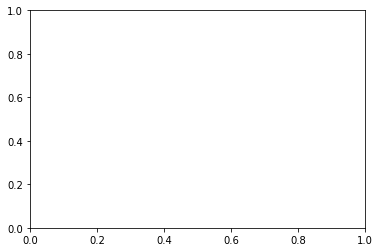

In [39]:
xgb.plot_importance(model3, figsize=(10,10))

In [38]:
evaluation_lgb = model2.evals_result_

In [39]:
print(evaluation_lgb['valid_0']['ndcg@5'][-1])

0.8857307653330544


In [40]:
from matplotlib import pyplot
# plot learning curves
pyplot.plot(evaluation_lgb['valid_0']['ndcg@5'], label='train')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

NameError: name 'evaluation_lgb' is not defined

C:\Users\Public\Anaconda\lib\site-packages\lightgbm\plotting.py:328: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


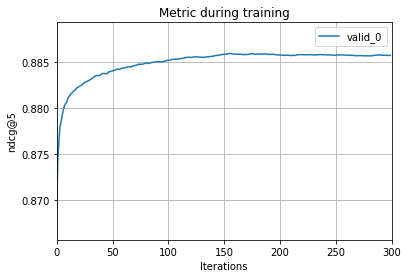

In [40]:
lgb.plot_metric(model2)

# XGBoost model

In [34]:
import xgboost as xgb

model3 = xgb.sklearn.XGBRanker(objective = 'rank:pairwise', learning_rate= 0.1,gamma= 1.0, min_child_weight= 0.1,
                                n_estimators= 200,subsample=0.7,max_depth=8,booster='dart', n_jobs = 4)
#gbtree or dart
model3.fit(X_train, y_train, train_groups, eval_set=[(X_val, y_val)], eval_group=[val_groups],eval_metric = 'ndcg')

C:\Users\Public\Anaconda\lib\site-packages\xgboost\core.py:430: FutureWarning: Pass `group` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  format(", ".join(args_msg)), FutureWarning)


XGBRanker(base_score=0.5, booster='dart', colsample_bylevel=1,
     colsample_bynode=1, colsample_bytree=1, gamma=1.0, gpu_id=-1,
     importance_type='gain', interaction_constraints='', learning_rate=0.1,
     max_delta_step=0, max_depth=8, min_child_weight=0.1, missing=nan,
     monotone_constraints='()', n_estimators=200, n_jobs=4,
     num_parallel_tree=1, objective='rank:pairwise', random_state=0,
     reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=0.7,
     tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
evaluation_xgb = model3.evals_result_

In [36]:
print(evaluation_xgb['validation_0']['ndcg'][-1])

0.899272


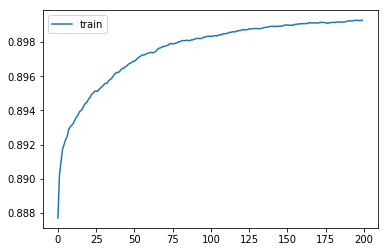

In [37]:
from matplotlib import pyplot
# plot learning curves
pyplot.plot(evaluation_xgb['validation_0']['ndcg'], label='train')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# Preparing the test data

In [22]:
test_data = pd.read_csv('test_set_VU_DM.csv') 

In [23]:
test_data['date_time'] = pd.to_datetime(test_data['date_time'])

test_data['Cin_hour'] = test_data["date_time"].apply(lambda x: x.hour)
test_data['Cin_day'] = test_data["date_time"].apply(lambda x: x.day)
test_data['Cin_month'] = test_data["date_time"].apply(lambda x: x.month)
test_data['Cin_quarter'] = test_data["date_time"].apply(lambda x: x.quarter)
test_data['Cin_day_of_week'] = test_data['date_time'].dt.dayofweek+1 #we don't want zeros

test_data.drop('date_time',axis=1,inplace=True)

In [24]:
test_data['priceRank'] = test_data.groupby('srch_id')['price_usd'].rank()
test_data['starRank'] = test_data.groupby('srch_id')['prop_starrating'].rank()
test_data['reviewRank'] = test_data.groupby('srch_id')['prop_review_score'].rank()
test_data['location1Rank'] = test_data.groupby('srch_id')['prop_location_score1'].rank()
test_data['location2Rank'] = test_data.groupby('srch_id')['prop_location_score2'].rank()
test_data['histpriceRank'] = test_data.groupby('srch_id')['prop_log_historical_price'].rank()

In [25]:
test_data['rating_diff']=abs(test_data['visitor_hist_starrating']-test_data['prop_starrating'])
test_data['rating_diff']=test_data['rating_diff'].fillna(test_data['rating_diff'].mean())

test_data['price_diff']=abs(test_data['visitor_hist_adr_usd']-test_data['price_usd'])
test_data['price_diff']=test_data['price_diff'].fillna(test_data['price_diff'].mean())

In [26]:
test_data['competitor_rate'] = (test_data.comp1_rate + test_data.comp2_rate + test_data.comp3_rate +
                                test_data.comp4_rate + test_data.comp5_rate + test_data.comp6_rate +
                                test_data.comp7_rate + test_data.comp8_rate)

test_data['competitor_inv'] = (test_data.comp1_inv + test_data.comp2_inv + test_data.comp3_inv +
                               test_data.comp4_inv + test_data.comp5_inv + test_data.comp6_inv +
                               test_data.comp7_inv + test_data.comp8_inv)

test_data['competitor_rpd'] = (  test_data.comp1_rate_percent_diff + test_data.comp2_rate_percent_diff
                               + test_data.comp3_rate_percent_diff + test_data.comp4_rate_percent_diff
                               + test_data.comp5_rate_percent_diff + test_data.comp6_rate_percent_diff
                               + test_data.comp7_rate_percent_diff + test_data.comp8_rate_percent_diff)/8/100

test_data.drop('comp1_rate',axis=1,inplace=True)
test_data.drop('comp2_rate',axis=1,inplace=True)
test_data.drop('comp3_rate',axis=1,inplace=True)
test_data.drop('comp4_rate',axis=1,inplace=True)
test_data.drop('comp5_rate',axis=1,inplace=True)
test_data.drop('comp6_rate',axis=1,inplace=True)
test_data.drop('comp7_rate',axis=1,inplace=True)
test_data.drop('comp8_rate',axis=1,inplace=True)
test_data.drop('comp1_inv',axis=1,inplace=True)
test_data.drop('comp1_rate_percent_diff',axis=1,inplace=True)
test_data.drop('comp2_inv',axis=1,inplace=True)
test_data.drop('comp2_rate_percent_diff',axis=1,inplace=True)
test_data.drop('comp3_inv',axis=1,inplace=True)
test_data.drop('comp3_rate_percent_diff',axis=1,inplace=True)
test_data.drop('comp4_inv',axis=1,inplace=True)
test_data.drop('comp4_rate_percent_diff',axis=1,inplace=True)
test_data.drop('comp5_inv',axis=1,inplace=True)
test_data.drop('comp5_rate_percent_diff',axis=1,inplace=True)
test_data.drop('comp6_inv',axis=1,inplace=True)
test_data.drop('comp6_rate_percent_diff',axis=1,inplace=True)
test_data.drop('comp7_inv',axis=1,inplace=True)
test_data.drop('comp7_rate_percent_diff',axis=1,inplace=True)
test_data.drop('comp8_inv',axis=1,inplace=True)
test_data.drop('comp8_rate_percent_diff',axis=1,inplace=True)

In [27]:
test_data = test_data[test_data.price_usd < 1800]

In [28]:
test_data = test_data.fillna(0)

In [29]:
clustering_kmeans = MiniBatchKMeans(n_clusters=100)
test_data['hotel_cluster'] = clustering_kmeans.fit_predict(test_data)

In [30]:
test_data = test_data.sort_values('srch_id')
test_data = test_data.reset_index(drop =True)
test_data_search_ids = test_data.srch_id

test_data_groups = test_data.srch_id.value_counts(sort=True,ascending=True).sort_index()

srch_id = test_data.srch_id
prop_id = test_data.prop_id
test_data.drop(['srch_id'],axis=1,inplace=True)

In [31]:
def create_result(rankings,srch_id,prop_id):
    predictions = pd.DataFrame(rankings,columns=['probs'])
    predictions = predictions.join(srch_id)
    predictions = predictions.join(prop_id)
    final_table = predictions.sort_values(by=['srch_id', 'probs'], ascending=[True, False])
    final_table.reset_index(drop = True, inplace = True)
    final_table = final_table.drop('probs',axis =1)
    
    return(final_table)

# Method 1 - LightGBM

In [58]:
rankings_lgb = model2.predict(test_data)

In [59]:
final_table_lgb2 = create_result(rankings_lgb,srch_id,prop_id)
final_table_lgb2.to_csv('rankings_lgb_cluster_booking4.csv',index = False)

# Method 2 - XGBoost

In [32]:
rankings_xgb = model3.predict(test_data)

C:\Users\Public\Anaconda\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [33]:
final_table_xgb = create_result(rankings_xgb,srch_id,prop_id)
final_table_xgb.to_csv('rankings_xgb_cluster_300iterations.csv',index = False)

Compare LGB with XGB

In [62]:
table = pd.DataFrame()
table['srch_id'] = srch_id
table['prob_id_lgb'] = final_table_lgb2['prop_id']
table['prob_id_xgb'] = final_table_xgb['prop_id']
print(table)

         srch_id  prob_id_lgb  prob_id_xgb
0              1        99484        99484
1              1        54937        54937
2              1        61934        61934
3              1        24194        24194
4              1        28181        28181
5              1        34263        63894
6              1        63894        82231
7              1        82231        34263
8              1        50162        50162
9              1        72090         5543
10             1        90385        90385
11             1         3180        78599
12             1         5543        72090
13             1        95031         3180
14             1       123675       123675
15             1        94729        95031
16             1        74045        74045
17             1       128085        94729
18             1        22393        22393
19             1        14142       128085
20             1        78599        14142
21             1        37567        73666
22         